In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import sys; sys.path += ['..', '../src']

Ok, here we gonna run style transfer for News<->Dostoevsky.

We gonna use approach from unsupervised-umt.ipynb (because it gave at least some results), but with shared vocabulary (with BPEs).
Style transfer looks like much more difficult thing than translation, because we have much more variants of "translation".

For evaluation we gonna use heuristic from [UMT paper](https://arxiv.org/abs/1711.00043): translate back and forth and check the BLEU.

Also we should not forget dumping translation examples into file during training.

TODO:
* Well, we have removed almost half of the sentences of the Dostoevsky by our strict limit of max_len=50. But this long sentences is quintessence of Dostoevsky's style!

In [3]:
# Let's currently use free GPU, which I've found on the server
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [4]:
import os
from itertools import islice

from src.vocab import Vocab

DATA_PATH = '../data/generated'

train_src_path = os.path.join(DATA_PATH, 'news.ru.tok.bpe')
train_trg_path = os.path.join(DATA_PATH, 'dostoevsky.tok.bpe')

# Well, let's read only part of the News corpora, because there is too much of it
with open(train_src_path, 'r', encoding='utf-8') as train_src_file:
    num_lines_to_take = 500000
    train_src = list(islice(train_src_file, num_lines_to_take))

train_trg = open(train_trg_path, 'r', encoding='utf-8').read().splitlines()

# Removing empty sentences and tokenizing
train_src = [s.split() for s in train_src if len(s) != 0]
train_trg = [s.split() for s in train_trg if len(s) != 0]

Let's remove too short and too long sentences because... because they are not cool

In [5]:
min_len = 10
max_len = 90

print('Num lines before:', len(train_src), len(train_trg))

train_src = [s for s in train_src if min_len < len(s) < (max_len - 2)]
train_trg = [s for s in train_trg if min_len < len(s) < (max_len - 2)]

print('Num lines after :', len(train_src), len(train_trg))

Num lines before: 500000 100937
Num lines after : 448201 79950


In [6]:
vocab = Vocab.from_sequences([' '.join(s) for s in (train_src + train_trg)])

In [7]:
train_src_idx = [[vocab.token2id[t] for t in s] for s in train_src]
train_trg_idx = [[vocab.token2id[t] for t in s] for s in train_trg]

In [8]:
from sklearn.model_selection import train_test_split

train_src_idx, val_src_idx = train_test_split(train_src_idx, test_size=1000, random_state=42)
train_trg_idx, val_trg_idx = train_test_split(train_trg_idx, test_size=1000, random_state=42)

In [9]:
import os

from src.transformer.models import Transformer
from src.utils.data_utils import load_embeddings, init_emb_matrix
from src.models import SimpleTransformerClassifier

transformer_kwargs = {
    'd_model': 512
}

transformer = Transformer(len(vocab), len(vocab), max_len, **transformer_kwargs)
discriminator = SimpleTransformerClassifier(2, max_len, **transformer_kwargs)

# Initializing transformer encoder and decoder with embeddings
embeddings = load_embeddings('../trained_models/dostoevsky-news.tok.bpe.skipgram.vec')

init_emb_matrix(transformer.encoder.src_word_emb.weight.data, embeddings, vocab.token2id)
init_emb_matrix(transformer.decoder.tgt_word_emb.weight.data, embeddings, vocab.token2id)

10895it [00:01, 7223.67it/s]


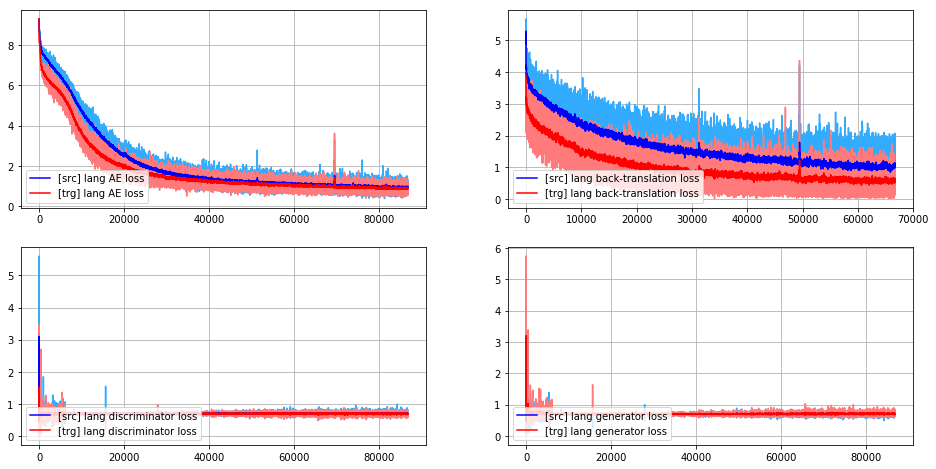

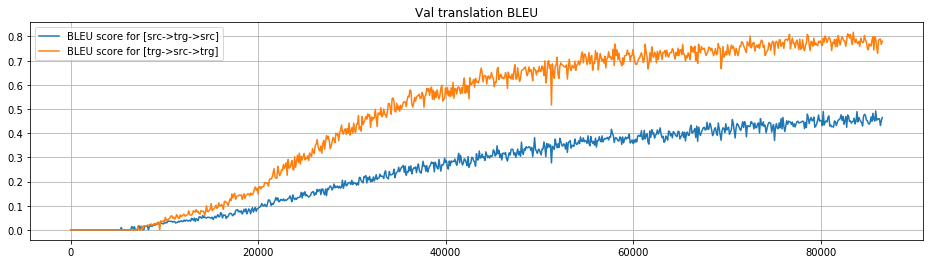

 79%|███████▊  | 7748/9869 [7:13:52<1:58:46,  3.36s/it]

In [ ]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import Adam

%matplotlib inline

from src.style_transfer_trainer import StyleTransferTrainer
from src.utils.umt_batcher import UMTBatcher
from src.utils.batcher import Batcher
import src.transformer.constants as constants

use_cuda = torch.cuda.is_available()
log_file_path = '../logs/style-transfer.log'

# Let's clean log file
if os.path.exists(log_file_path): os.remove(log_file_path)

def reconstruction_criterion(vocab_size):
    ''' With PAD token zero weight '''
    weight = torch.ones(vocab_size)
    weight[constants.PAD] = 0

    return nn.CrossEntropyLoss(weight)

reconstruct_src_criterion = reconstruction_criterion(len(vocab))
reconstruct_trg_criterion = reconstruction_criterion(len(vocab))
adv_criterion = nn.BCEWithLogitsLoss()

transformer_optimizer = Adam([
    {'params': transformer.get_trainable_params_without_embs(), 'lr': 1e-4},
    {'params': transformer.get_embs_parameters(), 'lr': 1e-5}
])
# transformer_optimizer = Adam(trainable_params_without_enc_embs(transformer), lr=1e-4)
discriminator_optimizer = Adam(discriminator.trainable_parameters(), lr=1e-4)

training_data = UMTBatcher(train_src_idx, train_trg_idx, vocab,
                           vocab, batch_size=8, shuffle=True)
val_data = Batcher(val_src_idx[:64], val_trg_idx[:64], vocab.token2id,
                   vocab.token2id, batch_size=8, shuffle=False)

training_config = {
    'max_num_epochs': 50,
    'start_bt_from_iter': 20000,
    'gen_loss_coef': 0.1,
    'log_file': '../logs/style_transfer.log'
}

trainer = StyleTransferTrainer(
    transformer, discriminator, vocab, vocab, transformer_optimizer, discriminator_optimizer,
    reconstruct_src_criterion, reconstruct_trg_criterion, adv_criterion, training_config)

trainer.run_training(training_data, val_data, plot_every=10, val_bleu_every=100)